----------解壓縮數據----------
----------Raw data loaded successfully----------
     digit  label
0  digit_1      4
1  digit_2      2
2  digit_3      3
3  digit_4      1
4  digit_5      2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 2 columns):
digit    1392 non-null object
label    1392 non-null int64
dtypes: int64(1), object(1)
memory usage: 21.8+ KB
None
AxesSubplot(0.125,0.125;0.775x0.755)
----------One-Hot Encoding----------
----------讀取並合併圖片----------


D:\Anaconda2\envs\parallel\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


----------顯示繪製圖像大小的分佈圖----------


D:\Anaconda2\envs\parallel\lib\site-packages\ipykernel_launcher.py:53: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


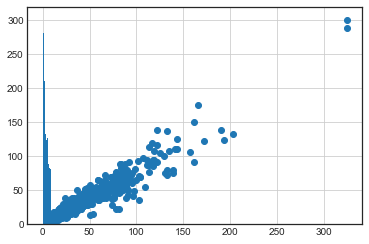

D:\Anaconda2\envs\parallel\lib\site-packages\ipykernel_launcher.py:68: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
D:\Anaconda2\envs\parallel\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
D:\Anaconda2\envs\parallel\lib\site-packages\ipykernel_launcher.py:91: DeprecationWarning: This function is deprecated. Please call randint(0, 1392 + 1) instead


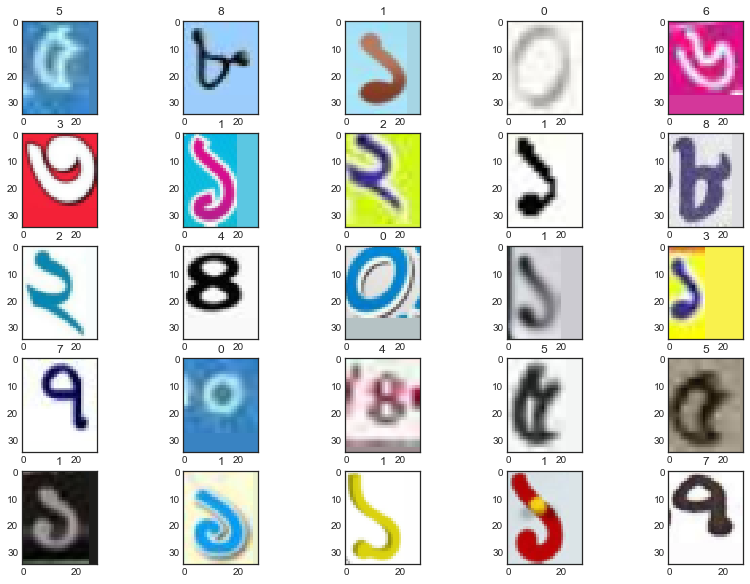

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 35, 28, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 26, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 33, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 11, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 14, 11, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 5, 32)          0         
__________

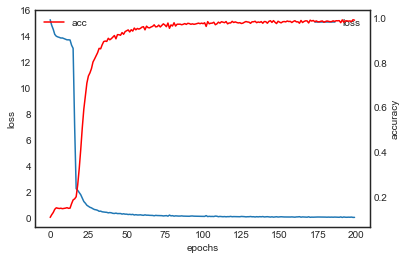

279/279 [==============================] - 0s 268us/step
loss, accuracy =  [0.091990699076951621, 0.98207885304659504]


In [9]:
import glob
from matplotlib.pyplot import subplots, show, figure, plot, xlabel, ylabel, legend, twinx, gca
from numpy import array, append, mean, argmin, ones, concatenate, uint8
from numpy.random import random_integers
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
from scipy.ndimage import imread
from scipy.ndimage.interpolation import zoom
from scipy.misc import imresize
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense


#Initial
sns.set_style('white')

#unzip
print('----------解壓縮數據----------')
z = zipfile.ZipFile('BDRW_train/BDRW_train_1.zip', "r")
for name in z.namelist():
    z.extract(name)
z = zipfile.ZipFile('BDRW_train/BDRW_train_2.zip', "r")
for name in z.namelist():
    z.extract(name)

#read data
labels = pd.read_excel('BDRW_train/labels.xls')
print('----------Raw data loaded successfully----------')
labels.columns = ['digit', 'label']
print(labels.head())
print(labels.info())
print(labels.label.hist())

#One-Hot Encoding
print('----------One-Hot Encoding----------')
dummies = pd.get_dummies(labels, columns = ['label'], )
one_hot_labels =array(dummies.drop('digit', axis = 1))

#read and merge pics
print('----------讀取並合併圖片----------')
image_list = []
#sort by labels.xls
for filename in sorted(glob.glob('BDRW_train_1/*.jpg'), key=lambda a: int(a.split("_")[-1].split('.')[0]))[1:]: #because digit_0 not in labels
    im=imread(filename)
    image_list.append(array(im))
for filename in sorted(glob.glob('BDRW_train_2/*.jpg'), key=lambda a: int(a.split("_")[-1].split('.')[0]))[:]:
    im=imread(filename)
    image_list.append(array(im))
#show
print('----------顯示繪製圖像大小的分佈圖----------')
shapes = array([x.shape for x in image_list]).T
plt.scatter(shapes[0], shapes[1])
plt.show()

#將所有圖像重新縮放至35x28，並用平均邊界線填充空白區域
def resize_and_fill(im, X=35, Y = 28):
    i = argmin(im.shape[:2])
    i = im.shape[0]/float(im.shape[1]) >= 1.25
    if i == 0:
        test_im = imresize(im, (int(im.shape[0]*float(Y)/im.shape[1]) , Y, 3) )
    if i == 1:
        test_im = imresize(im, (X, int(im.shape[1]*float(X)/im.shape[0]), 3) )

    shape_test = array(test_im.shape[:2])
    test_im2 = ones((X, Y ,3))
    if i == 0:
        for k in range(3):
            test_im2[:, :, k] = concatenate((test_im[:,:,k], ones((X-shape_test[0], Y))*mean(test_im[-1,:,k])), 0)

    if i == 1:
        for k in range(3):
            test_im2[:, :, k] = concatenate((test_im[:,:,k], ones((X, Y-shape_test[1]))*mean(test_im[:,-1,k])), 1)
    return test_im2.astype(uint8)
	
adjusted_im = array([resize_and_fill(x) for x in image_list])


#通過互補色來增加數據集
adjusted_im2 = append(adjusted_im, array([x[:,:,[1,0,2]] for x in adjusted_im]), 0)
one_hot_labels2 = append(one_hot_labels, one_hot_labels, 0)

fig, ax = subplots(5, 5, figsize = (14, 10))
for x in range(5):
    for y in range(5):
        rn = random_integers(0, len(adjusted_im))
        ax[x,y].imshow(adjusted_im[rn])
        ax[x,y].set_title(labels.label.iloc[rn])
show()


#用Keras創建CNN

earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

K.clear_session()

model = Sequential()
model.add(Dropout(0.3, input_shape=((35, 28, 3))))
model.add(Conv2D(32, (3, 3), input_shape=(35, 28, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())  #3D feature maps to 1D feature vectors
model.add(Dense(64, kernel_regularizer= 'l2'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, kernel_regularizer= 'l2'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'],)

model.summary()

X_train, X_test, y_train, y_test = train_test_split(adjusted_im2, one_hot_labels2, test_size = .1)

#start training
hist = model.fit(X_train, y_train, epochs = 200, batch_size = 128, verbose = False)


figure()
xlabel('epochs')
plot(hist.history['loss'])
ylabel('loss')
legend(['loss'])
twinx(gca())
plot(hist.history['acc'], 'r')
ylabel('accuracy')
legend(['acc'])
show()

print('loss, accuracy = ', model.evaluate(X_test, y_test))